<a href="https://colab.research.google.com/github/chenqinkai/bert/blob/master/colab/rnn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

import necesary libs and define some important hyper-params

In [0]:
import numpy as np
np.random.seed(0)
from keras.models import Sequential
from keras.layers import LSTM, Dropout, Dense, GRU, SimpleRNN
from keras.optimizers import Adam
# to make sure that the generated model is the same for each time
np.random.seed(1)
import os
import pandas as pd
from matplotlib import pyplot as plt
import tensorflow as tf

MAX_LEN = 96  # @param {type:"integer"}
EMBEDDING_SIZE = 768  # @param {type:"integer"}
LAYER = 1 # @param {type:"integer"}
WE_ARE_ON_GCP = True  # @param {type:"boolean"}
USE_TUNED_MODEL = True # @param {type:"boolean"}
REMOVE_SW = False # @param {type:"boolean"}

if not WE_ARE_ON_GCP:
    from generate_embedding import generate_embedding_to_file
else:
    from google.colab import auth
    auth.authenticate_user()


Using TensorFlow backend.


Check we are using which device

In [0]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 12322244735819278263
, name: "/device:XLA_CPU:0"
device_type: "XLA_CPU"
memory_limit: 17179869184
locality {
}
incarnation: 5882356126239071888
physical_device_desc: "device: XLA_CPU device"
, name: "/device:XLA_GPU:0"
device_type: "XLA_GPU"
memory_limit: 17179869184
locality {
}
incarnation: 16120487038822505838
physical_device_desc: "device: XLA_GPU device"
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 14800692839
locality {
  bus_id: 1
  links {
  }
}
incarnation: 12847702572666445882
physical_device_desc: "device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5"
]


Some helper functions

In [0]:
def convert_to_one_hot(Y):
    '''
        Y: np.array
        return: np.array
    '''
    Y_oh = np.zeros((Y.shape[0], 2))
    Y_oh[:, 0] = 1 - Y
    Y_oh[:, 1] = Y
    return Y_oh


def get_accuracy(y_pred, y_test, percentile=1.0):
    df = pd.DataFrame()
    df['pred'] = (y_pred[:, 1] - 0.5) * 2
    df['test'] = (y_test - 0.5) * 2
    upper = df['pred'].quantile(1 - percentile / 2.)
    lower = df['pred'].quantile(percentile / 2.)
    df = df[(df['pred'] >= upper) | (df['pred'] <= lower)]
    correct = df[np.sign(df['pred']) == np.sign(df['test'])]
    return correct.shape[0] / float(df.shape[0])


def get_part_filename(file_path, part=1):
    return file_path[:-4] + "_part%d" % part + ".npy"

Prepare train and test data

In [0]:
# prepare dataframes for target
if WE_ARE_ON_GCP:
    data_dir = "gs://bert-news-sentiment/reuters/horizon_3"
else:
    pass
train_tsv_name = "training_horizon_3_percentile_10.tsv"
test_tsv_name = "test_horizon_3.tsv"

with tf.gfile.Open(os.path.join(data_dir, train_tsv_name), 'r') as f_train:
    df_train = pd.read_csv(f_train, index_col=0, sep='\t')
with tf.gfile.Open(os.path.join(data_dir, test_tsv_name), 'r') as f_test:
    df_test = pd.read_csv(f_test, index_col=0, sep='\t')

    
# prepare embeddings
if WE_ARE_ON_GCP:
    train_embedding_path = "gs://bert-news-sentiment/rnn/embedding/training_horizon_3_percentile_10_%s_layer_%d_maxlen_%d%s.npy" % ("tuned" if USE_TUNED_MODEL else "base", LAYER, MAX_LEN, "_nostop" if REMOVE_SW else "")
    test_embedding_path = "gs://bert-news-sentiment/rnn/embedding/test_horizon_3_%s_layer_%d_maxlen_%d%s.npy" % ("tuned" if USE_TUNED_MODEL else "base", LAYER, MAX_LEN, "_nostop" if REMOVE_SW else "")
else:
    pass

if MAX_LEN < 64:
    with tf.gfile.Open(train_embedding_path, 'rb') as f_train_emb:
        X_train = np.load(f_train_emb)
    Y_train = df_train['Label'].values
    Y_train_oh = convert_to_one_hot(Y_train)

    with tf.gfile.Open(test_embedding_path, 'rb') as f_test_emb:
        X_test = np.load(f_test_emb)
    Y_test = df_test['Label'].values


/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (5) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


Define model structure

In [0]:
LSTM_L1_SIZE = 256 # @param {type:"integer"}
LSTM_L2_SIZE = 128 # @param {type:"integer"}
LSTM_L3_SIZE = 64 # @param {type:"integer"}
LSTM_L4_SIZE = 0 # @param {type:"integer"}
DROPOUT_RATE = 0.5 # @param {type:"number"}
LEARNING_RATE = 2e-5 # @param {type:"number"}
MODEL_TYPE = "LSTM" # @param {type:"string"}
ACTIVATION = "relu" # @param {type:"string"}

model_type_dict = {
    "LSTM": LSTM,
    "GRU": GRU,
    "RNN": SimpleRNN
}
UNIT = model_type_dict[MODEL_TYPE]

def get_model(input_shape=(MAX_LEN, EMBEDDING_SIZE)):
    print("Start Initialzing Neural Network!")
    model = Sequential()
    model.add(UNIT(LSTM_L1_SIZE, return_sequences=True,
                   activation=ACTIVATION, input_shape=input_shape))
    model.add(Dropout(DROPOUT_RATE))
    model.add(UNIT(LSTM_L2_SIZE, return_sequences=(LSTM_L3_SIZE != 0), activation=ACTIVATION))
    model.add(Dropout(DROPOUT_RATE))
    if LSTM_L3_SIZE != 0:
        model.add(UNIT(LSTM_L3_SIZE, return_sequences=(LSTM_L4_SIZE != 0), activation=ACTIVATION))
        model.add(Dropout(DROPOUT_RATE))
        if LSTM_L4_SIZE != 0:
            model.add(UNIT(LSTM_L4_SIZE, return_sequences=False, activation=ACTIVATION))
            model.add(Dropout(DROPOUT_RATE))
    model.add(Dense(2, activation='softmax'))
    model.compile(loss='categorical_crossentropy',
                  optimizer=Adam(lr=LEARNING_RATE), metrics=['accuracy'])
    return model

model = get_model()
print(model.summary())

Start Initialzing Neural Network!
Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 96, 256)           1049600   
_________________________________________________________________
dropout_1 (Dropout)          (None, 96, 256)           0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 96, 128)           197120    
_________________________________________________________________
dropout_2 (Dropout)          (None, 96, 128)           0         
_________________________________________________________________
lstm_3 (LSTM)                (None, 64)                49408     
_____________________________________________________

Launch RNN training

In [0]:
if MAX_LEN >= 64:
    with tf.gfile.Open(train_embedding_path, 'rb') as f_train_emb:
        X_train = np.load(f_train_emb)
    Y_train = df_train['Label'].values
    Y_train_oh = convert_to_one_hot(Y_train)

EPOCH = 3 # @param {type:"number"}
BATCH_SIZE = 128 # @param {type:"integer"}
model.fit(x=X_train, y=Y_train_oh, epochs=EPOCH, batch_size=BATCH_SIZE, verbose=1)

if MAX_LEN >= 64:
    del X_train

Instructions for updating:
Use tf.cast instead.
Epoch 1/3
50000/50000 [==============================] - 186s 4ms/step - loss: 0.7044 - acc: 0.5861
Epoch 2/3
50000/50000 [==============================] - 183s 4ms/step - loss: 0.6855 - acc: 0.6112
Epoch 3/3
50000/50000 [==============================] - 182s 4ms/step - loss: 0.6921 - acc: 0.6155


Save model, OOS prediction, then plot accuracy

The model will be saved at: gs://bert-news-sentiment/rnn/model/reuters/berttuned_label-010_emd-768_maxlen-96_lstm-256-128-64_drop-050_epoch-3_lr-2_batch-128_layer-1_lstm_activation-relu
model saved
predicting test set part 1
predicting test set part 2
saving prediction result
plotting and saving result


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:45: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:47: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.


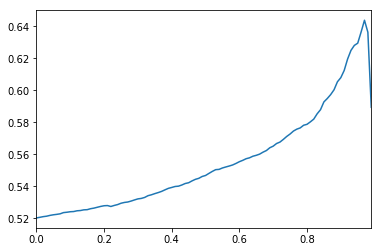

In [0]:
# save model
from tensorflow.python.lib.io import file_io
if WE_ARE_ON_GCP:
    model_dir = "gs://bert-news-sentiment/rnn/model/reuters/bert%s_label-010_emd-%d_maxlen-%d_lstm-%d-%d%s%s_drop-0%d_epoch-%d_lr-%d_batch-%d_layer-%d_%s%s_activation-%s" % (
        "tuned" if USE_TUNED_MODEL else "", EMBEDDING_SIZE, MAX_LEN, LSTM_L1_SIZE, LSTM_L2_SIZE, "" if LSTM_L3_SIZE == 0 else "-%d" % LSTM_L3_SIZE, "" if LSTM_L4_SIZE == 0 else "-%d" % LSTM_L4_SIZE, int(DROPOUT_RATE * 100), EPOCH, int(LEARNING_RATE * 1e5), BATCH_SIZE, LAYER, MODEL_TYPE.lower(), "_nostop" if REMOVE_SW else "", ACTIVATION)
else:
    model_dir = r"D:\data\bert_news_sentiment\reuters\model\bert%s_label-010_emd-%d_maxlen-%d_lstm-%d-%d_drop-0%d_epoch-%d_lr-%d_batch-%d_layer-%d%s" % (
        "tuned" if USE_TUNED_MODEL else "", EMBEDDING_SIZE, MAX_LEN, LSTM_L1_SIZE, LSTM_L2_SIZE, int(DROPOUT_RATE * 100), EPOCH, int(LEARNING_RATE * 1e5), BATCH_SIZE, LAYER, "_nostop" if REMOVE_SW else "")
print("The model will be saved at: %s" % model_dir)
if not tf.gfile.Exists(model_dir):
    tf.gfile.MakeDirs(model_dir)
model.save("model.h5")
with file_io.FileIO('model.h5', mode='rb') as input_f:
    with file_io.FileIO(os.path.join(model_dir, "model.h5"), mode='wb') as output_f:
        output_f.write(input_f.read())
print("model saved")

# out-of-sample prediction
if MAX_LEN < 64:
    y_pred = model.predict(X_test)
    with tf.gfile.Open(os.path.join(model_dir, "result.csv"), 'w') as f_result:
        pd.DataFrame(y_pred).to_csv(f_result, index=False, header=False)
else:
    print("predicting test set part 1")
    with tf.gfile.Open(get_part_filename(test_embedding_path, part=1), 'rb') as f_test_emb:
        X_test_1 = np.load(f_test_emb)
    y_pred_1 = model.predict(X_test_1)
    del X_test_1
    
    print("predicting test set part 2")
    with tf.gfile.Open(get_part_filename(test_embedding_path, part=2), 'rb') as f_test_emb:
        X_test_2 = np.load(f_test_emb)
    y_pred_2 = model.predict(X_test_2)
    del X_test_2
    y_pred = np.append(y_pred_1, y_pred_2, axis=0)
    Y_test = df_test['Label'].values

print("saving prediction result")
with tf.gfile.Open(os.path.join(model_dir, "pred.npy"), 'w') as f_pred:
    np.save(f_pred, y_pred)
    
# to plot and save plot
print("plotting and saving result")
s_accuracy = pd.Series()
for p in np.linspace(0.01, 1, 100):
    s_accuracy.set_value(1 - p, get_accuracy(y_pred, Y_test, p))
with tf.gfile.Open(os.path.join(model_dir, "accuracy.csv"), 'w') as f_accuracy:
    s_accuracy.to_csv(f_accuracy)
fig = plt.figure()
s_accuracy.sort_index().plot()
with tf.gfile.Open(os.path.join(model_dir, "accuracy.png"), 'w') as f_accuracy_plot:
    fig.savefig(f_accuracy_plot)